**EXPLORATORY DATA ANALYSIS (EDA) STAGE** \

ASSUMPTIONS: \
Previous pipeline stages have been completed. Therefore, we read the output of those stages as input for experimentation and evaluation in this stage. For example, data that has already been pre-processed and cleaned was saved in the previous stage so that we can read it and continue from there.

CODE LAYOUT: \
*   Similarly to the other scripts in this project, a main Configuration class stores all the properties/constants for all scripts/pipelines in this project. (See **Configuration** section)
*   A reusable class is created for the functionality contained within the script. In some cases you may see more than one class depending on the intended functionality. To test the models with varying preconditions, we make use of the same class, but with adjusted input information/data.(See **Reusable Code** section)
* The pattern followed is that the main Configuration class is instantiated once at the begining of the file and passed as a parameter to the reusable class. 

**Note:** If you see repeated classes across the different scripts or pipelines, such as the HelperFunction class, it is because I had an issue importing it. Ideally, these should be independent .py files that are imported into the script.



# Imports

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
!pip install nlpaug
!pip install transformers

     |████████████████████████████████| 4.9 MB 4.4 MB/s 
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 99 kB 10.3 MB/s 
     |████████████████████████████████| 352 kB 64.7 MB/s 
     |████████████████████████████████| 1.3 MB 54.1 MB/s 
     |████████████████████████████████| 238 kB 68.0 MB/s 
     |████████████████████████████████| 116 kB 61.0 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 1.1 MB 50.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 43.2 MB/s 
     |████████████████████████████████| 120 kB 51.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np

# Read/Write to file
import pickle

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for categorical encoding:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#for classification metrics:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#for dimensionality reduction:
from sklearn import preprocessing
from sklearn.decomposition import PCA

#for stratified sampling:
from sklearn.model_selection import StratifiedShuffleSplit

#for cross-validation and fine tuning:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

#for model-building
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#for classification metrics:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

# for deep learning models
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


# for data augmentation
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action


# fix random seed for reproducability
np.random.seed(10)

USING_COLAB = True
DRIVE_LOCATION = None

if USING_COLAB:
  #Mounting to Google Colab drive
  from google.colab import drive 
  drive.mount('/content/gdrive')
  DRIVE_LOCATION = '/content/gdrive/MyDrive/Colab Notebooks/AI_and_Machine_Learning_Module/Coursework/'
else:
  #python code is executed from with the working directory
  DATA_PATH = ''


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mounted at /content/gdrive


# Configuration

In [ ]:
class Configuration:
  clean_and_preprocess = None
  grid_search_tfidf_config = None
  tfidf_config = None
  model_selection_config = None
  deep_learning_config = None

  def __init__(self):
    self.clean_and_preprocess = CleanAndPreprocessConfig()
    self.grid_search_tfidf_config = GridSearchTFIDFConfig()
    self.tfidf_config = TFIDFConfig()
    self.model_selection_config = ModelSelectionConfig()
    self.deep_learning_config = DeepLearningConfig()

class CleanAndPreprocessConfig:
  _is_clean_and_preprocess=None
  _is_remove_duplicate_phrases=None
  _is_stopword=None
  _is_lemmatize=None 
  _is_label_encoder=None

  def __init__(self):
    self._is_clean_and_preprocess=True
    self._is_remove_duplicate_phrases=True
    self._is_stopword=True
    self._is_lemmatize=True 
    self._is_label_encoder=True

class TFIDFConfig:
  _is_use_defaults = None
  ngram_range = None,
  max_df=None,
  max_features=None

  def __init__(self):
    self._is_use_defaults = True



class GridSearchTFIDFConfig:
  pipe = None
  param_grid = None
  cv = None
  verbose = None
  model = None
  scoring = None

  def __init__(self):
    self.pipe = Pipeline ([
                           ("vec", TfidfVectorizer()),
                           ("clf", SVC())
                         ])
    self.param_grid = {
                        'vec__ngram_range': [(1, 1), (2, 2)],
                        'vec__max_features': [340,350, 360,None],
                        'vec__max_df':[1, 30, 35]
                      }
    self.cv = 5
    self.verbose = -1
    self.model = SVC()
    self.scoring = 'accuracy'

class ModelSelectionConfig:
  cross_validation_config = None
  svc_grid_search_config = None
  rf_grid_search_config = None

  def __init__(self):
    self.cross_validation_config = CrossValidationConfig()
    self.svc_grid_search_config = SVCGridSearchConfig()
    self.rf_grid_search_config = RandomForesetGridSearchConfig()

  
class CrossValidationConfig:
  cv = None
  scoring = None

  def __init__(self):
    self.cv = 10
    self.scoring = 'accuracy'

class SVCGridSearchConfig:
  param_grid = None
  cv = None

  def __init__(self):
    self.param_grid = {
                        'C': [0.001, 0.01, 0.1, 1, 10, 100],                   
                        'kernel': ['rbf', 'sigmoid']
                      }
    self.cv = 5

class RandomForesetGridSearchConfig:
  param_grid = None
  cv = None

  def __init__(self):

    self.param_grid = {
                        'n_estimators': [50, 100, 200],
                        'max_features': ['auto', 'sqrt', 'log2'],
                        'max_depth' : [4,5,6,7,8, None],          
                        'criterion' :['gini', 'entropy']
                      }
    self.cv=5

class DeepLearningConfig:

  tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
  tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

  drop_out = None
  loss = None
  optimizer = None
  metrics = None
  epochs = None
  test_pred_threshold = None
  learning_rate = None

  def __init__(self):
    self.drop_out = 0.01
    self.learning_rate = 3e-5
    self.loss = tf.keras.losses.BinaryCrossentropy()
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.metrics = [ 
                      tf.keras.metrics.BinaryAccuracy(),
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall'),
                      tf.keras.metrics.AUC(name='auc')
                   ]
    self.epochs = 10
    self.test_pred_threshold = 0.5

## Configuration Initialisation

In [ ]:
config = Configuration()

# Helper Functions

In [ ]:
class HelperFunctions:

  def readDataFromFile(self):
    mri_report_df = pd.read_excel(DRIVE_LOCATION + "Data/MRIreports.xlsx")
    mri_report_df.rename(columns={'Report Text': 'report_text', 'Tumour': 'tumour'}, inplace=True)
    return mri_report_df

  def plot_cm(self, actual, pred):
      cm = confusion_matrix(actual, pred)
      group_names = ['True Neg','False Pos','False Neg','True Pos']
      group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
      group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
      labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
      labels = np.asarray(labels).reshape(2,2)
      sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
      plt.title("Polynomial Logistic Regression Confusion Matrix")
      plt.ylabel('Actual label')
      plt.xlabel('Predicted label \n\n' + 
                "Accuracy: {:.2f}\n".format(accuracy_score(actual, pred)) + 
                "Precision: {:.2f}\n".format(precision_score(actual, pred, average='weighted')) + 
                "Recall: {:.2f}\n".format(recall_score(actual, pred, average='weighted')) +
                "F1: {:.2f}\n".format(f1_score(actual, pred, average='weighted')))

  def plot_roc_auc(self, actual, pred, pred_proba):
      fpr, tpr, thresholds = roc_curve(actual, pred_proba)
      roc_auc = roc_auc_score(actual, pred)
      plt.figure()
      plt.style.use('seaborn-whitegrid')
      plt.plot(fpr, tpr, color='darkorange', lw=1.5, label='ROC curve (area = %0.3f)' % roc_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()
  
  def show_metrics_save(self, y_labels, y_predictions, path, name):
    accuracy = accuracy_score(y_labels, y_predictions)
    precision = precision_score(y_labels, y_predictions)
    recall = recall_score(y_labels, y_predictions)
    auc = roc_auc_score(y_labels, y_predictions)
    df = pd.DataFrame(columns=['accuracy', 'precision','recall','AUC'], data=[[accuracy, precision, recall, auc]])
    df['Experiment'] = name
    self.writeToFile(df,path, name + '_result_DL')

    print("Accuracy: {:.2%}, Precision: {:.2%}, Recall: {:.2%}, AUC: {:.2}".format(accuracy, precision, recall, auc))
    print("\n Balanced Accuracy", balanced_accuracy_score(y_labels, y_predictions))
    self.plot_cm(y_labels, y_predictions)

  def show_metrics(self, y_labels, y_predictions):
    accuracy = accuracy_score(y_labels, y_predictions)
    precision = precision_score(y_labels, y_predictions)
    recall = recall_score(y_labels, y_predictions)
    auc = roc_auc_score(y_labels, y_predictions)
    print("Accuracy: {:.2%}, Precision: {:.2%}, Recall: {:.2%}, AUC: {:.2}".format(accuracy, precision, recall, auc))
    print("\n Balanced Accuracy", balanced_accuracy_score(y_labels, y_predictions))
    self.plot_cm(y_labels, y_predictions)

  def print_metrics(self, y_labels, y_predictions):    
      accuracy = accuracy_score(y_labels, y_predictions)
      precision = precision_score(y_labels, y_predictions)
      recall = recall_score(y_labels, y_predictions)
      auc = roc_auc_score(y_labels, y_predictions)
      print("Accuracy: {:.2%}, Precision: {:.2%}, Recall: {:.2%}, AUC: {:.2}".format(accuracy, precision, recall, auc))
      print('Confusion Matrix: \n',confusion_matrix(y_labels, y_predictions)) 
      print("\n Balanced Accuracy", balanced_accuracy_score(y_labels, 
                                                    y_predictions))
  def display_scores(self, scores):
      print("Scores:", scores)
      print("Mean:", scores.mean())
      print("Standard deviation:", scores.std())

  def convertCrossValScores(self, data, model_name):
    cross_val_df = pd.DataFrame(columns= ['cross_val_scores'], data= data)
    cross_val_df['model'] = model_name
    return cross_val_df

  def plotCrossValidationBarWithError(self, classifiers, labels):
    x_pos = np.arange(len(labels))
    CTEs = [classifier.mean() for classifier in classifiers]
    error = [classifier.std() for classifier in classifiers]

    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, CTEs,
          yerr=error,
          align='center',
          alpha=0.5,
          ecolor='black',
          capsize=20)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title('Cross Validation Scores for ML Model')
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('bar_plot_with_error_bars.png')
    plt.show()

  def writeToFile(self, object_to_write, path, name):
      location = DRIVE_LOCATION + path + name
      with open(location +'.pickle', 'wb') as output:
        pickle.dump(object_to_write, output)

  def readFromFile(self, path, name):
    location = DRIVE_LOCATION + path + name
    with open(location +'.pickle', 'rb') as data:
      features = pickle.load(data)
    return features

  #Let's create a reusable function to explore the word count through preprocessing
  def word_level_stats(self, data, column_name):
    words = []
    for document in data[column_name]:
        words.extend(document.split())

    total_words = len(words)
    print("Total Number of words:", total_words)

    unique_words = len(set(words))
    print("Total Number of unique words aka vocabulary size:", unique_words)

    average_count = int(total_words/unique_words)
    print("Average count:",average_count)
    
    return words

  def get_frequent_words(self, word_list, n):
    total_count = len(word_list)
    count_dict = dict(Counter(word_list))
    count_dict = sorted(count_dict.items(), key=lambda x: x[1], reverse = True)
    n_frequent = count_dict[:n]
    
    for word, count in n_frequent:
        print("word:{0}, percentage:{1}".format(word,round(count/total_count*100,2)))
    

# Instantiate/Initialize Reusable Classes

In [ ]:
config = Configuration()
helper = HelperFunctions()

# Read the Data

In [ ]:
mri_report_df = helper.readDataFromFile()


In [ ]:
mri_report_df.head()

report_text tumour
0  MR172016426 17/08/2017 MRI Internal auditory m...    Neg
1  MR202018745 29/10/2020 MRI Internal auditory m...    Neg
2  MR172024721 15/12/2017 MRI Internal auditory m...    Neg
3  MR182008748 07/03/2019 MRI IAM with contrast B...    Neg
4  MR182007437 26/04/2018 MRI Internal auditory m...    Neg

In [ ]:
mri_report_df.describe()

report_text tumour
count                                                6117   6117
unique                                               6112      2
top     MR IAMs\n\nAsymmetry in hearing, Right worse -...    Neg
freq                                                    3   5882

# Exploratory Data Analysis

- TODO: Add the fancy NLP popular word visualisation

In [ ]:
print(mri_report_df['tumour'][1000])
print(mri_report_df['report_text'][1000])

Neg
MR202021468 25/11/2020 MRI Internal auditory meatus Both

Clinical History:
Exclude vestibular schwannoma. Lt asymm HL. Patient has MS. Feels she would requiremedication to undertake MRI


Findings:
Both internal auditory meati and membranous labyrinths appear normal.  
No cerebellopontine angle lesion or posterior fossa abnormality is seen. In particular, no vestibular schwannoma is identified.

Tortuosity of the left vertebral artery is incidentally noted which is seen indenting and mildly displacing the brainstem to the right side. This is of no further clinical relevance.


Dr Shezad Hussain
Consultant Radiologist
GMC 4257916





In [ ]:
print(mri_report_df['tumour'][4665])
print(mri_report_df['report_text'][4665])


Pos
MR172001711 03/11/2017 MRI IAM with contrast Both

Clinical History:
known 5mm left acoustic neuroma. serial scan. November 2017 please


Findings:
Comparison with images from January 2017

Small 5 mm left-sided intra canalicular vestibular schwannoma, which has not changed in size since the last scan


Neil Derbyshire
Consultant Radiologist
GMC 2952257
Ext: 8905





Class distribution: imbalanced


Neg    5882
Pos     235
Name: tumour, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


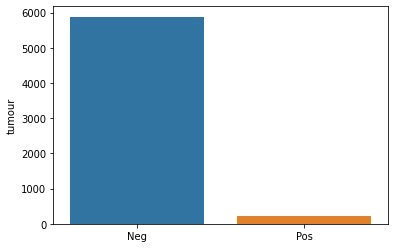

In [ ]:
x=mri_report_df['tumour'].value_counts()
print(x)
sns.barplot(x.index,x)

Extract out the patient ID and date into individual columns, check for duplicate ID's.

In [ ]:
#1. WORD COUNT
mri_report_df['word_count'] = mri_report_df['report_text'].apply(lambda x: len(str(x).split()))
print(mri_report_df[mri_report_df['tumour']=='Pos']['word_count'].mean()) #With Tumour
print(mri_report_df[mri_report_df['tumour']=='Neg']['word_count'].mean()) #No Tumour
print(mri_report_df[mri_report_df['tumour']=='Pos']['word_count'].std()) #With Tumour
print(mri_report_df[mri_report_df['tumour']=='Neg']['word_count'].std()) #No Tumour
print("--------")

#2. CHARACTER-COUNT
mri_report_df['char_count'] = mri_report_df['report_text'].apply(lambda x: len(str(x)))
print(mri_report_df[mri_report_df['tumour']=='Pos']['char_count'].mean()) #With Tumour
print(mri_report_df[mri_report_df['tumour']=='Neg']['char_count'].mean()) #No Tumour
#Positive tumour reports are longer than negative tumour reports

#3. UNIQUE WORD-COUNT
mri_report_df['unique_word_count'] = mri_report_df['report_text'].apply(lambda x: len(set(str(x).split())))
print(mri_report_df[mri_report_df['tumour']=='Pos']['unique_word_count'].mean()) #With Tumour
print(mri_report_df[mri_report_df['tumour']=='Neg']['unique_word_count'].mean()) #No Tumour



101.94468085106384
64.71353281196872
39.545726040641476
23.269994731082104
--------
707.5234042553192
492.46072764365863
82.28085106382979
58.74328459707583


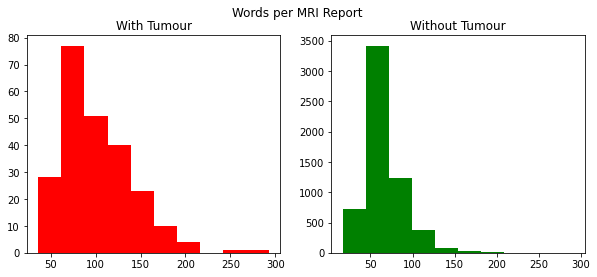

In [ ]:
#Plotting word-count per report
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
report_words=mri_report_df[mri_report_df['tumour']=='Pos']['word_count']
ax1.hist(report_words,color='red')
ax1.set_title('With Tumour')
report_words=mri_report_df[mri_report_df['tumour']=='Neg']['word_count']
ax2.hist(report_words,color='green')
ax2.set_title('Without Tumour')
fig.suptitle('Words per MRI Report')
plt.show()

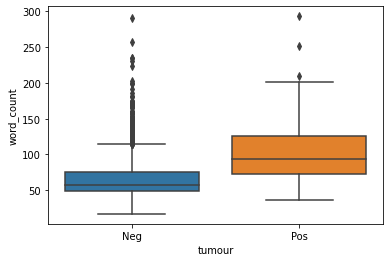

In [ ]:
sns.boxplot(x = 'tumour', y = 'word_count',data = mri_report_df)

In [ ]:
#Let's create a reusable function to explore the word count through preprocessing
def word_level_stats(data, column_name):
    words = []
    for document in data[column_name]:
        words.extend(document.split())

    total_words = len(words)
    print("Total Number of words:", total_words)

    unique_words = len(set(words))
    print("Total Number of unique words aka vocabulary size:", unique_words)

    average_count = int(total_words/unique_words)
    print("Average count:",average_count)
    
    return words

words = word_level_stats(mri_report_df,'report_text')

Total Number of words: 404602
Total Number of unique words aka vocabulary size: 19131
Average count: 21


In [ ]:
def get_frequent_words(word_list,n):
    total_count = len(word_list)
    count_dict = dict(Counter(word_list))
    count_dict = sorted(count_dict.items(), key=lambda x: x[1], reverse = True)
    n_frequent = count_dict[:n]
    
    for word, count in n_frequent:
        print("word:{0}, percentage:{1}".format(word,round(count/total_count*100,2)))
        
        
get_frequent_words(words,10)

word:the, percentage:2.23
word:auditory, percentage:2.09
word:Both, percentage:2.01
word:vestibular, percentage:1.83
word:is, percentage:1.82
word:and, percentage:1.81
word:MRI, percentage:1.68
word:of, percentage:1.67
word:No, percentage:1.6
word:Findings:, percentage:1.49


top 10 words occupy more than 18% of total words! Above all, most of these words don't even provide any information.
These words (the,and,of,...) are called stopwords and we generaly remove them. In addition, words like auditory, both and mri are repeated as the "MRI test type" conducted on the patient and can be considered for removal.

In [ ]:
mri_report_df = mri_report_df.drop(['word_count', 'char_count', 'unique_word_count'], axis=1)
